# Scattering Parameters (S-Parameters) 


## TODO: What are Scattering Parameters?

Scattering Parameters are values that represent linear characteristics of devices that operate at radio frequencies or higher and are used in both RF electronics and in photonics. For a given photonic device, while knowing the actual shape of the device is useful, what we really care about is how light propagates through it. S-Parameters give us this necessary information by telling us how much light will exit a given port based on how much light was inserted and where. 

For a device with N ports, there will be N<sup>2</sup> s-parameters, which are normally organized in an NxN matrix, ofen called the Scatter Matrix. Each S-parameter is a complex number that gives the magnitude and phase of the wave exiting the exit port given the wave entering the input port. The notation for S-Parameters is S<sub>(output port)(input port)</sub>. So, S<sub>13</sub> will be for the light entering port 3 and exiting port 1




## TODO: Why are S-Parameters useful?


## TODO: Demonstration of using simphony to simulate a circuit quickly using s-parameters


## How to find S-Parameters for an arbitrary device using a meep simulation

In this section we'll demonstrate how to find the s-params for any device using a meep simulation. We'll show both 2D and 3D simulations, but keep in mind that 2D s-params are not very accurate. We'll run through the steps using gdsfactory's default 2x2 mmi, and explain on the way how the principles can be applied to any component. There are other ways to find s-parameters, and another method is shown on the [Gds To Meep]() page

### Step 1 - Import Geometry

For our simulation, it makes life easy if we add all of our sources and detectors into our gds before we import it into meep. For this tutorial I have already done this. For your simulations, you can modify your gds file directly in Klayout if you like a GUI, or you can use gdsfactory itself. If you like, you can also use meep to do the same thing, but I won't be showing how to do that here. This tutorial is adapted from the [GDSII Import](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) tutorial on the meep documentation

Here is a picture of the gds we will be using. 

![Image of splitter file](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mmi2x2_gds_with_ports.png)

I've added a box around the entire component (in purple) which will become the simulation region, and 8 lines, 2 on each end that will become the sources and detectors. I also added straight waveguides on the ports of the gdsfactory mmi so that my ports could be exactly where the light would enter and exit the component in an actual circuit. My sources are then slightly outside the mmi, in the waveguides.

So, now that we have a gds, lets import it into meep!

In [13]:
# Imports
import meep as mp 
import numpy
import matplotlib.pyplot as plt 
import math

Next we'll define a whole bunch of variables so our code is more readable down the line. 

In [14]:
res = 50 # the resolution of the simulation in pixels/um
three_d = False # Turn this to false for a 2D simulation

gds_file = "mmi2x2.gds" # The name of our gds file

# Here we define the layer numbers for each part of our gds
geometry_L = 1
cell_L = 2
port1_L = 4
port2_L = 3
port3_L = 5
port4_L = 6
source1_L = 8
source2_L = 7
source3_L = 9
source4_L = 10

# The Parameters for the frequencies we'll be using
lcen = 1.55 # Center wavelength
fcen = 1 / lcen # Center frequency
df = 0.2*fcen # Frequency Diameter

# The thickness of each material in our simulation (only used in 3D simulations)
t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1 # Diameter of perfectly matched layers
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml # Cell thickness

# The materials we will have in our simulation, silicon and SiO2
oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)

# Sets the min and max values for the cell and the silicon. Our simulation will be centered at y=0
cell_zmax = 0.5*cell_thickness if three_d else 0
cell_zmin = -0.5 * cell_thickness if three_d else 0
si_zmax = 0.5 * t_Si if three_d else 10 # In a 2D simulation, the geometry still has to have a thickness or it won't show up
si_zmin = -0.5 * t_Si if three_d else -10

# Create a 2D array to hold the S-Parameters for the device
numPorts = 4 # The number of ports, also the size of our array
s_params = [[0 for i in range(numPorts)] for j in range(numPorts)]
input_params = [0 for i in range(numPorts)]


Now, we'll import our geometries from the gds file

In [15]:
###################################################
# Now we actually import the geometry
geometry = mp.GDSII_prisms(silicon, gds_file, geometry_L, zmax=si_zmax, zmin=si_zmin) # Gets the geometry of the mmi
cell = mp.GDSII_vol(fname = gds_file, layer = cell_L, zmax=cell_zmax, zmin=cell_zmin) # cell geometry. We use mp.GDSII_vol() instead of mp.GDSII_prims() because they return different types
port1 = mp.GDSII_vol(fname = gds_file, layer = port1_L, zmax=cell_zmax, zmin=cell_zmin) # Port geometry
port2 = mp.GDSII_vol(fname = gds_file, layer = port2_L, zmax=cell_zmax, zmin=cell_zmin)
port3 = mp.GDSII_vol(fname = gds_file, layer = port3_L, zmax=cell_zmax, zmin=cell_zmin)
port4 = mp.GDSII_vol(fname = gds_file, layer = port4_L, zmax=cell_zmax, zmin=cell_zmin)
source1 = mp.GDSII_vol(fname = gds_file, layer = source1_L, zmax=cell_zmax, zmin=cell_zmin) # Source Geometry
source2 = mp.GDSII_vol(fname = gds_file, layer = source2_L, zmax=cell_zmax, zmin=cell_zmin)
source3 = mp.GDSII_vol(fname = gds_file, layer = source3_L, zmax=cell_zmax, zmin=cell_zmin)
source4 = mp.GDSII_vol(fname = gds_file, layer = source4_L, zmax=cell_zmax, zmin=cell_zmin)
if three_d:
    cell_plane = mp.GDSII_vol(fname = gds_file, layer = cell_L, zmax=0, zmin=0) # the plane of the cell. This is used to plot the simulation when it is three_d
else:
    cell_plane = cell


if three_d: # Sets up the oxide cladding for a three d simulation (Not used in a 2D simulation)
    oxide_center = mp.Vector3(z=-0.5 * t_oxide)
    oxide_size = mp.Vector3(cell.size.x, cell.size.y, t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry + oxide_layer


### Step 2: Run simulation for a single source

In order to find all the S-Parameters for a device, we have to run a simulation for each port. Each time we switch where the source is, and then get the S-parameters from that port. So, for this component, I'll run 4 simulations, each time injecting the light into a different port. Then I'll calculate the S-parameters between the port that has the light, and every other port. 

Because I added geometry for the sources in the gds, we just have to input that geometry into the source instead of constructing it in meep. 
TODO: Explain briefly why we use the eig_parity we do, and what the eig_band and eig_match_freq

Once we define the source in meep, we can create a simulation object by simply passing all of the necessary parts into the contructor. 

In [16]:
# Set up the first source for the simulation. I'll start with port1 (the lower left)
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source1.size, # Here we input the geometry for our first source
            center=source1.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    )
]

# Create Simulation
sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell.size, # The cell size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the perfectly matched layers, with a diameter as defined above
    sources = sources, # The source(s) we just defined
    geometry = geometry # The geometry, from above
)


After creating the simulation object, we can add mode monitors at each of the ports. These will read how much light comes in/out of each port. 

Now that our simulation is completely set up for the first source, I can plot it to make sure everything looks right before running the simulation. We do that using the plot2D() method of the simulation object.

     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,-1.125,-10)
      

<Axes: xlabel='X', ylabel='Y'>

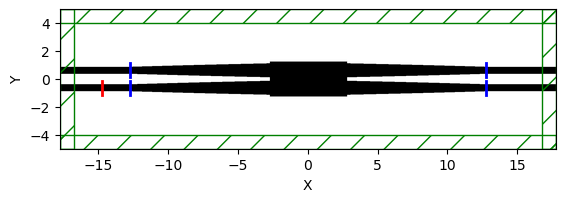

In [17]:
# Adds mode monitors at each of the ports to track the energy that goes in or out, then adds them to a list
modeMonitors = []
modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port1))) # Adds mode monitor for the frequency fcen, at only that frequency
modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port2)))
modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port3)))
modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port4)))

# Plot the simulation
sim.plot2D(output_plane = cell_plane) # No parameters are needed for a 2D simulation. 

As we see from the output of sim.plot2D(), our simulation is set up correctly. The red is our source, the blue are our 4 mode monitors, an the black is the geometry. We are ready to run the simulation! Actually running the simulation is the most computationally intense part of this, so it may take some time. The until_after_sources parameter for sim.run() means the run the simulation until 100 meep time units after the sources have turned off. This makes sure the all of the light has time to propagate through the mmi.

In [18]:
# Runs the simulation
sim.run(until_after_sources=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00280905 s
Working in 2D dimensions.
Computational cell is 35.5 x 10 x 0 with resolution 50
     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon dia

Now that our simulation has been run, we'll quickly compute the s-parameters, store them in our array, and print them out. The function sim.get_eigenmode_coefficients() returns an array that holds the parameters for every mode, every frequency, and in the forward and backward direction. In our simulation we only simulated the fundamental TE mode and at only our center frequency. For most applications, only the fundamental TE mode matters, but often we do want to see how the S-parameters change with frequency. To do that, simply change the df and nfreq parameters for the mode monitors. However, in our simulation we do care about the direction. In our simulation, light will go in port 1 going forward (towards positive X) and exit ports 3 and 4 in the same direction, but any light exiting port 1 and 2 will be going backwards (towards negative X). So, we change the alpha to be (0,0,1) for port 1 and 2. The 1 in the third spot indicates the backward propagating light. We'll also see how much light is inserted at port 1 going forward.

In [19]:
#############################################################
alphas = [[1,1,0,0,0], [1,1,0,0,0],[1,1,0,0,1],[1,1,0,0,1]] # This array holds the values for forwards and backward propagation for each soure. The 5th number is for the total input
# Finds the S parameters
input_coeff = sim.get_eigenmode_coefficients(modeMonitors[0], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[0][4]] # This is the amount of light from the source that enters the device
port1_coeff = sim.get_eigenmode_coefficients(modeMonitors[0], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[0][0]]
port2_coeff = sim.get_eigenmode_coefficients(modeMonitors[1], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[0][1]]
port3_coeff = sim.get_eigenmode_coefficients(modeMonitors[2], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[0][2]]
port4_coeff = sim.get_eigenmode_coefficients(modeMonitors[3], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[0][3]]
# Store the S parameters in s_params
s_params[0] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]
input_params[0] = input_coeff


# Prints out the S parameters
print("\n-----------------------------------------------------------------\n")
print("S params: Port1(Lower Left, S11): {:.6f}  Port2(Upper Left, S12): {:.6f}  Port3(Upper Right, S13): {:.6f}  Port4(Lower Right, S14): {:.6f}".format(port1_coeff, port2_coeff, port3_coeff, port4_coeff))
print("\n-----------------------------------------------------------------\n")



MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 22 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 22 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 22 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) =

Just for fun, we'll also compute and print the transmittance through each port and the total insertion loss. We won't do this with the other ports, but it's a good exercise here. 

We find that this component is actually terrible and would never be used in an actual photonic design. Almost a third of the light is lost, and the light that isn't lost is not split in any specific ratio. Fortunately, it was never meant to be used, and just exists as an example of the basic shape of an mmi.

In [20]:
# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2 / abs(input_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2 / abs(input_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2 / abs(input_coeff) ** 2
port4_trans = abs(port4_coeff) ** 2 / abs(input_coeff) ** 2

# Calculates the Insertion loss as a percent and in dB
insertionLoss = 1-(port2_trans + port3_trans + port4_trans)
insertionLoss_dB = 10*math.log10(insertionLoss) 

# Prints the Transmittance
print("\n-----------------------------------------------------------------\n")
print("Transmittance/Reflectance: Port1: {:.6f}% Port2: {:.6f}%, Port3: {:.6f}%, Port4: {:.6f}%".format(port1_trans*100, port2_trans*100, port3_trans*100, port4_trans*100))
print("Insertion Loss: {:.6f}% -> {:.6f}db".format(insertionLoss*100, insertionLoss_dB))
print("\n-----------------------------------------------------------------\n")




-----------------------------------------------------------------

Transmittance/Reflectance: Port1: 0.091326% Port2: 0.225287%, Port3: 6.601279%, Port4: 61.515984%
Insertion Loss: 31.657450% -> -4.995241db

-----------------------------------------------------------------



Finally, before we move on to the next step, we'll run the simulation again and create a plot of the steady state of the mmi. 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00160384 s
Working in 2D dimensions.
Computational cell is 35.5 x 10 x 0 with resolution 50
     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon dia

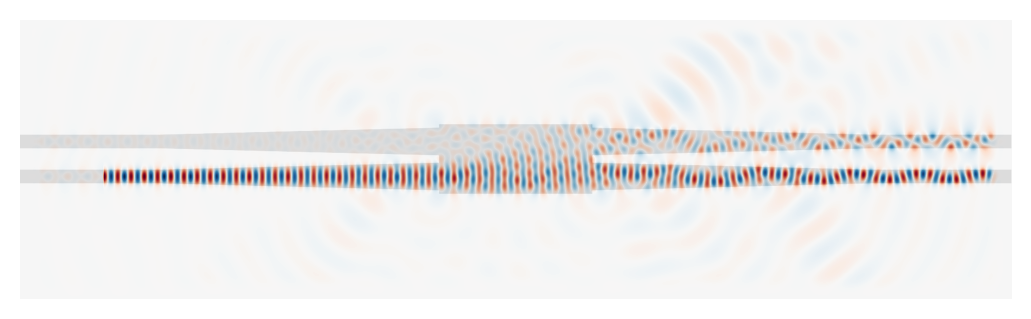

In [21]:
# Reset the simulation in order to run it again and visulaize the fields
sim.reset_meep()

# Create a continuous source
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(fcen, fwidth=df),
        size=source1.size,
        center=source1.center,
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

# Sets up the simulation again
sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

# Runs the simulation for a long time to ensure that the fields have reached a steady state
sim.run(
    until=300
)

# Gets data
eps_data = sim.get_epsilon() # Epsilon Data / The Geometry / An array that holds what materials are where
ez_data = numpy.real(sim.get_efield_z()) # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
plt.figure(dpi=200)
plt.imshow(numpy.transpose(eps_data), interpolation="spline36", cmap="binary")
plt.imshow(
    numpy.flipud(numpy.transpose(ez_data)),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
plt.axis("off")
plt.show()

### Step 3: Run the same simulation for each of the other ports

Now, all that's left to do is to run the simulation for each source. Here, I'll use a for loop to run the other three simulations. We could have done this for all four, but hopefully this makes the code make more sense. 

For the sources going into port 3 and 4, we have to specify that the light will be propagating backwards. Below, I've done this by setting the direction to mp.NO_DIRECTION and using the eig_kpoint parameter to specify the direction. You can use this same method to launch sources in any direction. 

It should be noted, that since the 2x2 mmi we are using is symmetrical across both the x and y axies, the S-parameters should be the same for all of the other ports. But for the sake of demonstration, we'll simulate all of them. Then at then end we can check to see the the S-parameters are actually the same. 

In [22]:

# Set up the rest of the sources for the simulation.
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source2.size, # Here we input the geometry for our first source
            center=source2.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source3.size, # Here we input the geometry for our first source
            center=source3.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source4.size, # Here we input the geometry for our first source
            center=source4.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    )
]

In [23]:


for i in range(numPorts-1) :

    source = sources[i:i+1]

    sim.reset_meep() # resets everything

    # Create Simulation
    sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell.size, # The cell size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the perfectly matched layers, with a diameter as defined above
    sources = source, # The source(s) we just defined
    geometry = geometry # The geometry, from above
    )
    
    # Adds mode monitors at each of the ports to track the energy that goes in or out
    modeMonitors = []
    modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port1)))
    modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port2)))
    modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port3)))
    modeMonitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port4)))

    # Runs the simulation
    sim.run(until_after_sources=100)

    #############################################################
    # Finds the S parameters
    port1_coeff = sim.get_eigenmode_coefficients(modeMonitors[0], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][0]]
    port2_coeff = sim.get_eigenmode_coefficients(modeMonitors[1], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][1]]
    port3_coeff = sim.get_eigenmode_coefficients(modeMonitors[2], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][2]]
    port4_coeff = sim.get_eigenmode_coefficients(modeMonitors[3], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][3]]
    input_coeff = sim.get_eigenmode_coefficients(modeMonitors[i+1], [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][4]] # This is the total amount of light that entered the devie

    # Store the S parameters in s_params
    index = 1+i 
    s_params[index] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]
    input_params[index] = input_coeff

-----------
Initializing structure...
time for choose_chunkdivision = 0.00362706 s
Working in 2D dimensions.
Computational cell is 35.5 x 10 x 0 with resolution 50
     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon dia

In [24]:
print("S-Params:")
for i in range(numPorts):
    print(f"S{i+1}1: {s_params[i][0]}\tS{i+1}2: {s_params[i][1]}\tS{i+1}3: {s_params[i][2]}\tS{i+1}4: {s_params[i][3]}")

print("Input S-Params")
print(f"S1: {input_params[0]}\tS2: {input_params[1]}\tS3: {input_params[2]}\tS4: {input_params[3]}")



print("Transmission:")
for i in range(numPorts):
    input_power = abs(input_params[i])**2
    trans1 = abs(s_params[i][0])**2 / input_power * 100
    trans2 = abs(s_params[i][1])**2 / input_power * 100
    trans3 = abs(s_params[i][2])**2 / input_power * 100
    trans4 = abs(s_params[i][3])**2 / input_power * 100
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(trans1, trans2, trans3, trans4))




S-Params:
S11: (0.14960817169459495+0.18094806104759972j)	S12: (0.10267041589942087+0.3541789490101426j)	S13: (1.8619031794718912+0.7196374503550248j)	S14: (-1.2433181680562757-5.965356735591374j)
S21: (0.10267041899067682+0.35417894822327617j)	S22: (0.1496081756122604+0.18094806585728018j)	S23: (-1.2433182965094123-5.965357368445672j)	S24: (1.861901683987171+0.7196382153116293j)
S31: (1.8618449429222623+0.7178469664415132j)	S32: (-1.2433332720946273-5.965300180252111j)	S33: (0.1498160792690407+0.18073202551487394j)	S34: (0.10283168723619183+0.35410857505000864j)
S41: (-1.2433332729747244-5.965300184431863j)	S42: (1.861844935820673+0.7178469702063446j)	S43: (0.10283182573003818+0.35410861869374605j)	S44: (0.14981620140746998+0.1807331866788009j)
Input S-Params
S1: (2.0738370300493054+7.487298837148062j)	S2: (2.073837028980689+7.4872988385060015j)	S3: (2.07368110892212+7.487194315803298j)	S4: (2.0736811497999605+7.487194287317847j)
Transmission:
0.091326	0.225287	6.601279	61.515984
0.22

Above, we can see all of the S-parameters from the simulations, and we can verify that the S-parameters are in fact the same for every port, which is what we expected. We also calculated the transmission which is also the same no matter what port we use. 

### S-Parameters across different Frequencies

For most applications, you'll want to know the S-parameters across a range of frequencies. This can be done using the simulations created here. When we get the S-parameters using the sim.get_eigenmode_coefficients().alpha[] we get a matrix. The first entry in the matrix specifies the wavelength. For brevities sake, we won't show that here, but a good exercise would be to find and plot the s-paramters across a range of frequencies for the component shown here. 

## References

[MathWorks](https://www.mathworks.com/discovery/s-parameter.html#:~:text=S%2Dparameters%20(also%20called%20S,standing%20wave%20ratio%20(VSWR).)

https://docs.lucedaphotonics.com/guides/caphe_models_frequency/scatter_matrix

https://www.microwaves101.com/encyclopedias/s-parameters


https://www.youtube.com/watch?v=-Pi0UbErHTY



